In [1]:
%run common.ipynb

In [2]:
SPP = ['gambiae', 'coluzzii']
METRIC = 'hamming'

# Single amplicon processing

In [3]:
# sample names per species
sps = dict()
for sp in SPP:
    sps[sp] = samples.loc[samples.species==sp, 'ox_code']
display([x.shape for x in sps.values()])

[(654,), (283,)]

In [4]:
# read amplicon data
ampl = '60'
callset = zarr.open_group(AMPL_HAP_ZARR, 'r')
gt = allel.GenotypeArray(callset[ampl]['calldata/genotype'])
# extract samples - those differ between autosome and X
gs = pd.Series(callset[ampl]['samples'][:])

In [5]:
# nuber of variants
nvar = gt.shape[0]

In [6]:
# extract genotypes per species
gts = dict()
for sp in SPP:
    gts[sp] = gt[:, gs.isin(sps[sp]), :]
display([x.shape for x in gts.values()])

[(37, 573, 2), (37, 280, 2)]

In [7]:
# convert to haplotypes
hts = dict()
for sp in SPP:
    hts[sp] = gts[sp].reshape(gts[sp].shape[0], 2 * gts[sp].shape[1]).transpose()
display([x.shape for x in hts.values()])

[(1146, 37), (560, 37)]

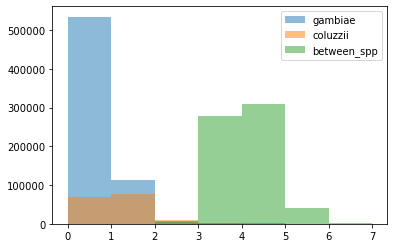

In [8]:
# pairwise distances
pds = dict()
# within sp
for sp in SPP:
    pds[sp] = pdist(hts[sp], metric=METRIC)
# between spp for pairwise combinations of species
pds['between_spp'] = np.array([])
for (sp1, sp2) in itertools.combinations(SPP, 2):
    pds['between_spp'] = np.append(pds['between_spp'],
                                   cdist(hts[sp1],hts[sp2], metric=METRIC))
# combine multiple
for (sp, dist) in pds.items():
    plt.hist(dist * nvar, bins=range(8), alpha=0.5, label=sp);
plt.legend();

# Batch processing 

In [9]:
callset = zarr.open_group(AMPL_HAP_ZARR, 'r')
# accumulate pairwise distances into dict
pds = dict()

for ampl in callset:
    sys.stdout.write('\r' + ampl)
    pds[ampl] = dict()
    # read genotypes
    gt = allel.GenotypeArray(callset[ampl]['calldata/genotype'])
    # extract samples - those differ between autosome and X amplicons
    gs = pd.Series(callset[ampl]['samples'][:])
    # nuber of variants
    pds[ampl]['nvar'] = gt.shape[0]
    # extract genotypes per species
    gts = dict()
    for sp in SPP:
        gts[sp] = gt[:, gs.isin(sps[sp]), :]
    # convert to haplotypes
    hts = dict()
    for sp in SPP:
        hts[sp] = gts[sp].reshape(gts[sp].shape[0], 2 * gts[sp].shape[1]).transpose()
    # pairwise distances
    # within sp
    for sp in SPP:
        pds[ampl][sp] = pdist(hts[sp], metric=METRIC)
    # between spp for pairwise combinations of species
    pds[ampl]['between_spp'] = np.array([])
    for (sp1, sp2) in itertools.combinations(SPP, 2):
        pds[ampl]['between_spp'] = np.append(pds[ampl]['between_spp'],
                                             cdist(hts[sp1],hts[sp2], metric=METRIC))

91

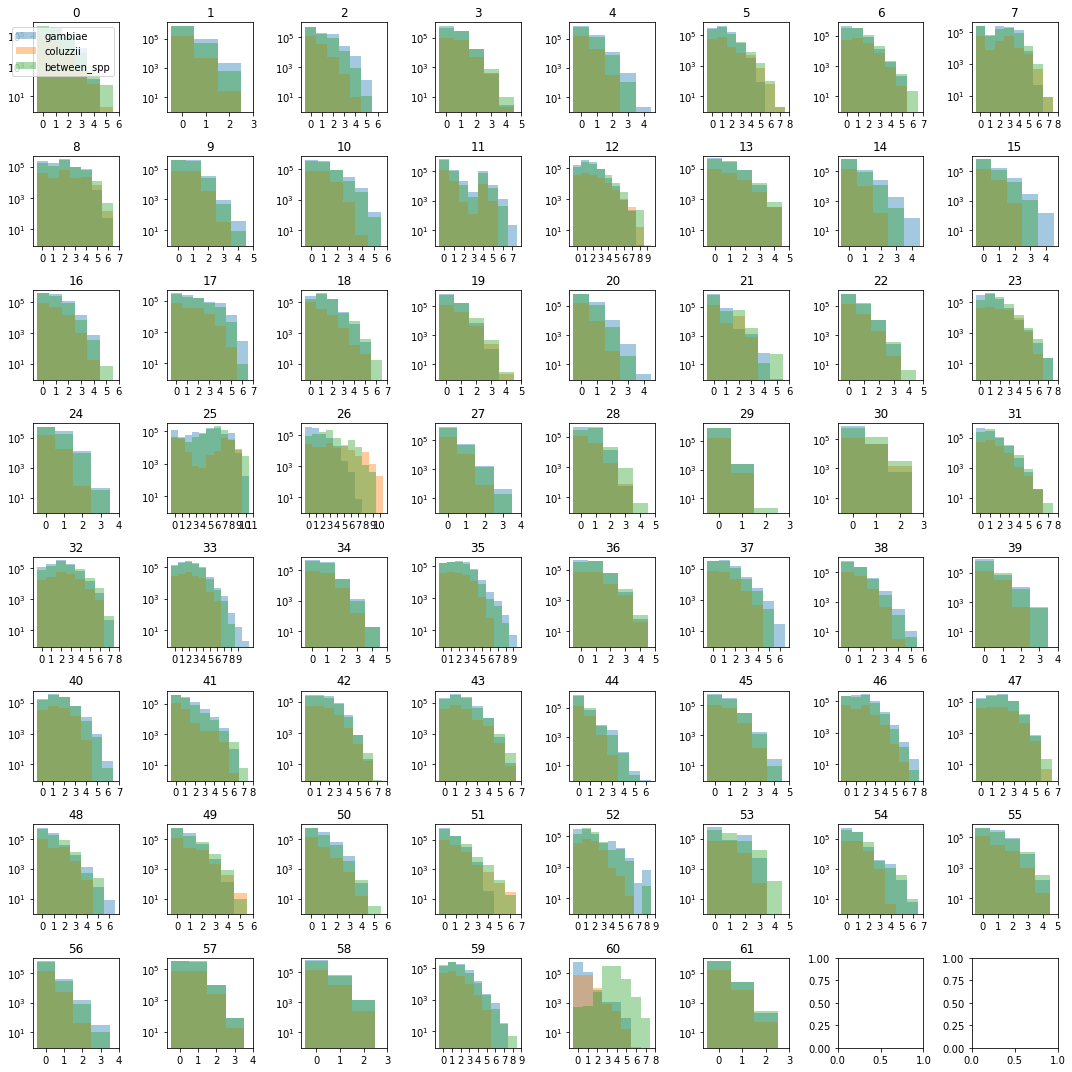

In [10]:
fig, axs = plt.subplots(8,8, figsize=(15,15))
for i, ampl in enumerate(AMPLS):
    ax = axs.flatten()[i]
    n = pds[ampl]['nvar']
    for sp in SPP + ['between_spp']:
        pd_var = pds[ampl][sp] * n
        bins = np.arange(0, int(pd_var.max()) + 1.5) - 0.5
        ax.hist(pd_var, 
                bins=bins, 
                alpha=0.4,
                label=sp);
        ax.set_xticks(bins + 0.5)
        if i == 0:
            ax.legend()
    ax.set_title(ampl)
#     ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim(0.9)
    
fig.tight_layout()

## Within-species distance thresholds

Above debug histogram shows that in most cases the distributions of pairwise distances between haplotypes are contiguous, thus taking maximum observed within-species distances will work as a threshold. The only doubtful amplicon is 33, where gambiae is far much more variable than both coluzzii and between-species.

In [11]:
var_data = panel_mosquito.loc[:, ['start_insert','end_insert']].reset_index()

In [12]:
# sequence length in agam genome, both start and end positions taken into insert by subsetting code 
# (see previous notebook)
var_data['len_insert'] = var_data.end_insert - var_data.start_insert + 1

In [13]:
# find maximum within-species distances across both species
def max_sp_pd_var(ampl):
    max_sp_dist = [max(pds[ampl][sp]) for sp in SPP]
    return max(max_sp_dist) * pds[ampl]['nvar']
var_data['max_withinspecies_var'] = var_data.Primary_ID.apply(max_sp_pd_var)

In [14]:
# normalise by sequence length
var_data['max_withinspecies_dist'] = var_data.max_withinspecies_var / var_data.len_insert
var_data.head()

,Primary_ID,start_insert,end_insert,len_insert,max_withinspecies_var,max_withinspecies_dist
0,0,10356439,10356587,149,5.0,0.033557
1,1,10357476,10357629,154,2.0,0.012987
2,2,12084517,12084667,151,6.0,0.039735
3,3,13862890,13863031,142,4.0,0.028169
4,4,18693503,18693693,191,4.0,0.020942


In [15]:
# write
var_data.to_csv(WSP_VAR_FILE, index=False)
! head {WSP_VAR_FILE}

Primary_ID,start_insert,end_insert,len_insert,max_withinspecies_var,max_withinspecies_dist
0,10356439,10356587,149,5.0,0.03355704697986577
1,10357476,10357629,154,2.0,0.012987012987012988
2,12084517,12084667,151,6.0,0.039735099337748346
3,13862890,13863031,142,4.0,0.028169014084507043
4,18693503,18693693,191,4.0,0.020942408376963352
5,19065193,19065344,152,7.0,0.046052631578947366
6,20840408,20840599,192,5.0,0.026041666666666668
7,26760718,26760865,148,7.0,0.0472972972972973
8,27674665,27674814,150,6.0,0.04


## Compare to previous estimates

In [16]:
# estimate based on extended sample set
seq_wsp_file = '../../../data/phylo_ampl_dada2/comb1_5/3_thresholds.tsv'
seq_wsp = pd.read_csv(seq_wsp_file, sep='\t')
seq_wsp.head()

,target,dist_threshold
0,0,0.088000
1,1,0.039216
2,2,0.064039
3,3,0.043478
4,4,0.052632


In [17]:
# convert to dict
seq_t = seq_wsp.set_index('target')['dist_threshold'].to_dict()
var_data['seq_threshold'] = var_data.Primary_ID.astype(int).replace(seq_t)

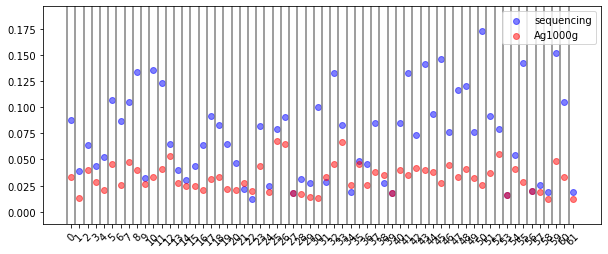

In [18]:
fig, ax = plt.subplots(1,1, figsize=(10,4))
ax.scatter(var_data.Primary_ID.astype(int), var_data.seq_threshold, c='b', alpha=0.5, label='sequencing')
ax.scatter(var_data.Primary_ID.astype(int), var_data.max_withinspecies_dist, c='r', alpha=0.5, label='Ag1000g')
ticks = range(62)
ax.set_xticks(ticks)
plt.xticks(rotation=45)
for t in ticks:
    ax.axvline(t - 0.5, c='grey')
ax.legend();

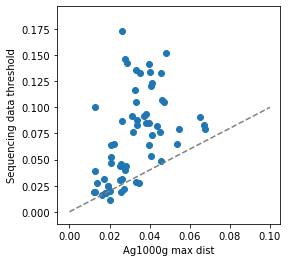

In [19]:
fig, ax = plt.subplots(1,1, figsize=(4,4))
ax.scatter(var_data.max_withinspecies_dist, 
           var_data.seq_threshold)
ax.set_xlabel('Ag1000g max dist')
ax.set_ylabel('Sequencing data threshold')
ax.plot([0, 0.1], [0, 0.1], c='grey', ls='--');

Thresholds are underestimated for the most variable compared to sequencing data - potentially because of lack of indel data?